In [1]:
#!pip install Xgboost

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.tree import plot_tree
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd
df = pd.read_csv("penguins_lter.csv")
df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo),Comments
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.1,18.7,181.0,3750.0,MALE,NaN,NaN,Not enough blood for isotopes.
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.5,17.4,186.0,3800.0,FEMALE,8.94956,-24.69454,NaN
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.3,18.0,195.0,3250.0,FEMALE,8.36821,-25.33302,NaN
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Adult not sampled.
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.7,19.3,193.0,3450.0,FEMALE,8.76651,-25.32426,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 344 entries, 0 to 343
Data columns (total 17 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   studyName            344 non-null    object 
 1   Sample Number        344 non-null    int64  
 2   Species              344 non-null    object 
 3   Region               344 non-null    object 
 4   Island               344 non-null    object 
 5   Stage                344 non-null    object 
 6   Individual ID        344 non-null    object 
 7   Clutch Completion    344 non-null    object 
 8   Date Egg             344 non-null    object 
 9   Culmen Length (mm)   342 non-null    float64
 10  Culmen Depth (mm)    342 non-null    float64
 11  Flipper Length (mm)  342 non-null    float64
 12  Body Mass (g)        342 non-null    float64
 13  Sex                  334 non-null    object 
 14  Delta 15 N (o/oo)    330 non-null    float64
 15  Delta 13 C (o/oo)    331 non-null    flo

In [5]:
df.isnull().sum()

studyName                0
Sample Number            0
Species                  0
Region                   0
Island                   0
Stage                    0
Individual ID            0
Clutch Completion        0
Date Egg                 0
Culmen Length (mm)       2
Culmen Depth (mm)        2
Flipper Length (mm)      2
Body Mass (g)            2
Sex                     10
Delta 15 N (o/oo)       14
Delta 13 C (o/oo)       13
Comments               318
dtype: int64

In [6]:
# Drop useless column
df = df.drop(columns=["Comments"])

In [7]:
# Numeric values fill with mean
num_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
            'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
for i in num_cols:
    df[i] = df[i].fillna(df[i].mean())

In [8]:
Gender = df["Sex"].mode()[0]
df["Sex"] = df["Sex"].fillna(Gender)
rare_values = df["Sex"].value_counts()[df["Sex"].value_counts() < 2].index.tolist()
df["Sex"] = df["Sex"].replace(rare_values, Gender)

In [9]:
# One-hot encode features

df_features = df.drop(columns=["Sex"])
cat_cols = df_features.select_dtypes(include=["object"]).columns.tolist()

X = pd.get_dummies(df_features, columns=cat_cols, drop_first=True)
y = df["Sex"]

df.head()

,studyName,Sample Number,Species,Region,Island,Stage,Individual ID,Clutch Completion,Date Egg,Culmen Length (mm),Culmen Depth (mm),Flipper Length (mm),Body Mass (g),Sex,Delta 15 N (o/oo),Delta 13 C (o/oo)
0,PAL0708,1,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A1,Yes,11/11/07,39.10000,18.70000,181.000000,3750.000000,MALE,8.733382,-25.686292
1,PAL0708,2,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N1A2,Yes,11/11/07,39.50000,17.40000,186.000000,3800.000000,FEMALE,8.949560,-24.694540
2,PAL0708,3,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A1,Yes,11/16/07,40.30000,18.00000,195.000000,3250.000000,FEMALE,8.368210,-25.333020
3,PAL0708,4,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N2A2,Yes,11/16/07,43.92193,17.15117,200.915205,4201.754386,MALE,8.733382,-25.686292
4,PAL0708,5,Adelie Penguin (Pygoscelis adeliae),Anvers,Torgersen,"Adult, 1 Egg Stage",N3A1,Yes,11/16/07,36.70000,19.30000,193.000000,3450.000000,FEMALE,8.766510,-25.324260


In [10]:
df['Sex'].value_counts()

Sex
MALE      179
FEMALE    165
Name: count, dtype: int64

In [11]:
df['Sex'].value_counts(normalize=True) * 100

Sex
MALE      52.034884
FEMALE    47.965116
Name: proportion, dtype: float64

# Train/Test Split

In [12]:
le = LabelEncoder()
y = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

## Scale numeric

In [13]:
# Scale numeric
numeric_cols = ['Culmen Length (mm)', 'Culmen Depth (mm)', 'Flipper Length (mm)',
                'Body Mass (g)', 'Delta 15 N (o/oo)', 'Delta 13 C (o/oo)']
num_cols_in_X = [c for c in X.columns if c in numeric_cols]

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_test_scaled = X_test.copy()

X_train_scaled[num_cols_in_X] = scaler.fit_transform(X_train[num_cols_in_X])
X_test_scaled[num_cols_in_X] = scaler.transform(X_test[num_cols_in_X])

# Naive Bayes Classification

In [14]:
nb = GaussianNB()
nb

GaussianNB()

In [15]:
nb.fit(X_train_scaled, y_train)
nb_pred = nb.predict(X_test_scaled)

In [16]:
y_train_pred = nb.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.52


In [17]:
print(F"Accuracy:", accuracy_score(y_test, nb_pred))
print(F"\nClassification Report:\n", classification_report(y_test, nb_pred, target_names=le.classes_))

Accuracy: 0.6231884057971014

Classification Report:
               precision    recall  f1-score   support

      FEMALE       0.58      0.76      0.66        33
        MALE       0.69      0.50      0.58        36

    accuracy                           0.62        69
   macro avg       0.64      0.63      0.62        69
weighted avg       0.64      0.62      0.62        69



> Inference
  * Naive Bayes performs poorly on this dataset, with only ~62% accuracy.
  * Naive Bayes misclassifies many samples, especially MALE penguins, and shows weak overall performance.
      * It catches FEMALEs well (76% recall).
        * → Moderate performance.
      * But misses many MALEs (only 50% recall).
        * → Weak performance.
  * Therefore, Naive Bayes is not suitable for this dataset and should not be chosen as the final model.

## Hyperparameter Tuning 

In [82]:
params = {'var_smoothing': [1e-9, 1e-8, 1e-7]}
grid = GridSearchCV(GaussianNB(), params, cv=5)
grid.fit(X, y)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07]})

In [83]:
best_na = grid.best_estimator_
best_na

GaussianNB(var_smoothing=1e-07)

In [84]:
y_pred_best = best_na.predict(X_test)
print(f"Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
print(f"\nClassification Report (tuned RF):\n", classification_report(y_test, y_pred_best))

Tuned RF Accuracy: 0.9565217391304348

Classification Report (tuned RF):
               precision    recall  f1-score   support

           0       0.97      0.94      0.95        33
           1       0.95      0.97      0.96        36

    accuracy                           0.96        69
   macro avg       0.96      0.96      0.96        69
weighted avg       0.96      0.96      0.96        69



# KNN Classification

In [18]:
knn = KNeighborsClassifier()
knn

KNeighborsClassifier()

In [19]:
knn = KNeighborsClassifier(n_neighbors=10)

In [20]:
knn.fit(X_train_scaled, y_train)
knn_pred = knn.predict(X_test_scaled)

In [21]:
print(f"Accuracy:", accuracy_score(y_test, knn_pred))
print(f"\nClassification Report:\n", classification_report(y_test, knn_pred, target_names=le.classes_))

Accuracy: 0.4492753623188406

Classification Report:
               precision    recall  f1-score   support

      FEMALE       0.43      0.45      0.44        33
        MALE       0.47      0.44      0.46        36

    accuracy                           0.45        69
   macro avg       0.45      0.45      0.45        69
weighted avg       0.45      0.45      0.45        69



## Hyperparameter Tuning 

In [23]:
k=range(3,20)

In [77]:
def elbow_method(k):
    test_f1=[]
    for i in k:
        Kclass = KNeighborsClassifier(n_neighbors=i, metric="euclidean").fit(X_train, y_train)
        pr = Kclass.predict(X_test)
        f1=f1_score(pr, y_test)
        error= 1-f1
        test_f1.append(error)
    return test_f1

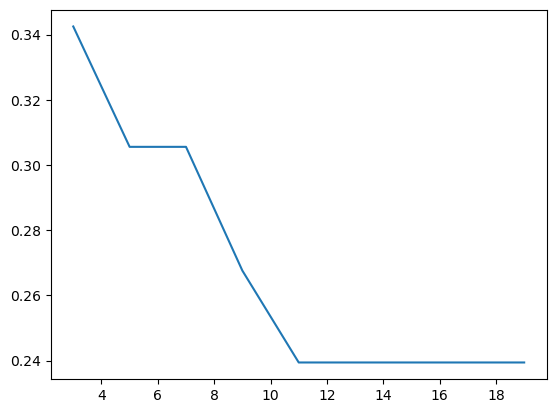

In [78]:
k=range(3,20,2)
testing=elbow_method(k)
#testing
import matplotlib.pyplot as plt
plt.plot(k, testing)

In [85]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

params = {
    'n_neighbors': [3,5,7,9,11],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(KNeighborsClassifier(), params, cv=5)
grid.fit(X, y)

print(grid.best_params_)
print(grid.best_score_)

{'metric': 'euclidean', 'n_neighbors': 11, 'weights': 'uniform'}
0.7031543052003411


In [86]:
knn = KNeighborsClassifier(n_neighbors=11, weights="uniform", metric="euclidean")

In [88]:
knn.fit(X_train_scaled, y_train)
knn_pred1 = knn.predict(X_test_scaled)

In [89]:
print(f"Accuracy:", accuracy_score(y_test, knn_pred))
print(f"\nClassification Report:\n", classification_report(y_test, knn_pred1))

Accuracy: 0.4492753623188406

Classification Report:
               precision    recall  f1-score   support

           0       0.48      0.33      0.39        33
           1       0.52      0.67      0.59        36

    accuracy                           0.51        69
   macro avg       0.50      0.50      0.49        69
weighted avg       0.50      0.51      0.49        69



# Logistic Regression

In [29]:
lr = LogisticRegression()
lr

LogisticRegression()

In [30]:
lr = LogisticRegression(max_iter=1000)

In [31]:
lr.fit(X_train_scaled, y_train)
lr_pred = lr.predict(X_test_scaled)

In [32]:
y_train_pred = lr.predict(X_train)
train_accuracy = accuracy_score(y_train, y_train_pred)
print("Training Accuracy:", train_accuracy)

Training Accuracy: 0.52


In [33]:
print(f"Accuracy:", accuracy_score(y_test, lr_pred))
print(f"\nClassification Report:\n", classification_report(y_test, lr_pred, target_names=le.classes_))

Accuracy: 0.8405797101449275

Classification Report:
               precision    recall  f1-score   support

      FEMALE       0.89      0.76      0.82        33
        MALE       0.80      0.92      0.86        36

    accuracy                           0.84        69
   macro avg       0.85      0.84      0.84        69
weighted avg       0.85      0.84      0.84        69



> Inference
 * Logistic Regression gives strong, reliable performance with ~84% accuracy.
 * The model shows balanced precision and recall across both classes, indicating it captures the linear relationships in the penguin dataset
   effectively.
 * Scaling helps the model fit properly.

# Support Vector Machine (SVM) 

In [34]:
param_grid = {'C': [0.1, 1, 10, 50],'gamma': ['scale', 'auto', 0.01, 0.001],'kernel': ['rbf','linear'] }

In [35]:
grid = GridSearchCV(SVC(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 32 candidates, totalling 160 fits


GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10, 50],
                         'gamma': ['scale', 'auto', 0.01, 0.001],
                         'kernel': ['rbf', 'linear']},
             scoring='accuracy', verbose=1)

In [36]:
print(f"Best params from GridSearch:", grid.best_params_)
best_svm = grid.best_estimator_


Best params from GridSearch: {'C': 1, 'gamma': 'scale', 'kernel': 'linear'}


In [37]:
best_pred = best_svm.predict(X_test_scaled)
print(f"GridSearch best SVM accuracy:", accuracy_score(y_test, best_pred))
print(f"\nClassification report:\n", classification_report(y_test, best_pred, target_names=le.classes_))
print(f"\nConfusion matrix:\n", confusion_matrix(y_test, best_pred))

GridSearch best SVM accuracy: 0.8840579710144928

Classification report:
               precision    recall  f1-score   support

      FEMALE       0.90      0.85      0.88        33
        MALE       0.87      0.92      0.89        36

    accuracy                           0.88        69
   macro avg       0.89      0.88      0.88        69
weighted avg       0.89      0.88      0.88        69


Confusion matrix:
 [[28  5]
 [ 3 33]]


> Inference
  * The Support Vector Machine with GridSearch tuning achieved the best performance.
  * Extremely balanced performance
     * Both classes (Male & Female) are predicted with high precision and recall.
  * The matrix shows very few errors and strong separation between classes.

# Random Forest Classifier

## Random Forest (default hyperparams)

In [38]:
# Random Forest (default hyperparams)
rf = RandomForestClassifier(random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [39]:
print(f"Baseline RF Accuracy:", accuracy_score(y_test, y_pred))
print(f"\nClassification Report:\n", classification_report(y_test, y_pred))
print(f"\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

Baseline RF Accuracy: 0.855072463768116

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.82      0.92      0.87        36

    accuracy                           0.86        69
   macro avg       0.86      0.85      0.85        69
weighted avg       0.86      0.86      0.85        69


Confusion Matrix:
 [[26  7]
 [ 3 33]]


In [40]:
importances = pd.Series(rf.feature_importances_, index=X.columns)
top20 = importances.sort_values(ascending=False).head(20)
print(f"\nTop 20 feature importances:\n", top20)


Top 20 feature importances:
 Body Mass (g)                                        0.194074
Culmen Depth (mm)                                    0.145838
Culmen Length (mm)                                   0.105905
Flipper Length (mm)                                  0.080883
Delta 15 N (o/oo)                                    0.064923
Delta 13 C (o/oo)                                    0.055992
Sample Number                                        0.040018
Species_Gentoo penguin (Pygoscelis papua)            0.014957
Date Egg_11/9/07                                     0.008922
Species_Chinstrap penguin (Pygoscelis antarctica)    0.008307
Island_Dream                                         0.006289
studyName_PAL0910                                    0.006122
studyName_PAL0809                                    0.005467
Date Egg_12/1/09                                     0.005145
Island_Torgersen                                     0.004405
Individual ID_N6A1                      

## Using GridSearchCV to tune hyperparameters

In [41]:
# GridSearchCV to tune hyperparameters
param_grid = {'n_estimators': [100, 250, 500],'max_depth': [None, 6, 12, 20],'min_samples_split': [2, 5, 10],'max_features': ['sqrt', 'log2', 0.5]}

In [42]:
grid = GridSearchCV(RandomForestClassifier(random_state=42), param_grid,cv=5, scoring='accuracy', n_jobs=-1, verbose=1)
grid.fit(X_train, y_train)

Fitting 5 folds for each of 108 candidates, totalling 540 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [None, 6, 12, 20],
                         'max_features': ['sqrt', 'log2', 0.5],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [100, 250, 500]},
             scoring='accuracy', verbose=1)

In [43]:
print(f"\nGridSearch best params:", grid.best_params_)
best_rf = grid.best_estimator_


GridSearch best params: {'max_depth': None, 'max_features': 0.5, 'min_samples_split': 2, 'n_estimators': 250}


In [44]:
y_pred_best = best_rf.predict(X_test)
print(f"Tuned RF Accuracy:", accuracy_score(y_test, y_pred_best))
print(f"\nClassification Report (tuned RF):\n", classification_report(y_test, y_pred_best))
print(f"\nConfusion Matrix (tuned RF):\n", confusion_matrix(y_test, y_pred_best))

Tuned RF Accuracy: 0.8695652173913043

Classification Report (tuned RF):
               precision    recall  f1-score   support

           0       0.90      0.82      0.86        33
           1       0.85      0.92      0.88        36

    accuracy                           0.87        69
   macro avg       0.87      0.87      0.87        69
weighted avg       0.87      0.87      0.87        69


Confusion Matrix (tuned RF):
 [[27  6]
 [ 3 33]]


# DECISION TREE CLASSIFIER

In [45]:
dt = DecisionTreeClassifier(random_state=42)
dt.fit(X_train, y_train)

DecisionTreeClassifier(random_state=42)

In [46]:
y_pred_dt = dt.predict(X_test)

In [47]:
print("Accuracy:", accuracy_score(y_test, y_pred_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_dt))

Accuracy: 0.8260869565217391

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79        33
           1       0.77      0.94      0.85        36

    accuracy                           0.83        69
   macro avg       0.85      0.82      0.82        69
weighted avg       0.84      0.83      0.82        69


Confusion Matrix:
 [[23 10]
 [ 2 34]]


## Hyperparameter Tuning (GridSearch)

In [48]:
param_grid = {"criterion": ["gini", "entropy"], "max_depth": [None, 3, 5, 10, 15, 20], "min_samples_split": [2, 5, 10], "min_samples_leaf": [1, 2, 4]}

In [49]:
grid_dt = GridSearchCV( DecisionTreeClassifier(random_state=42), param_grid, cv=5, scoring='accuracy', n_jobs=-1, verbose=1)

In [50]:
grid_dt.fit(X_train, y_train)
print("\nBest Parameters:", grid_dt.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters: {'criterion': 'gini', 'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2}


In [74]:
best_dt = grid_dt.best_estimator_
best_dt

DecisionTreeClassifier(max_depth=3, random_state=42)

In [52]:
y_pred_best_dt = best_dt.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred_best_dt))
print("\nClassification Report:\n", classification_report(y_test, y_pred_best_dt))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_best_dt))

Accuracy: 0.8260869565217391

Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.70      0.79        33
           1       0.77      0.94      0.85        36

    accuracy                           0.83        69
   macro avg       0.85      0.82      0.82        69
weighted avg       0.84      0.83      0.82        69


Confusion Matrix:
 [[23 10]
 [ 2 34]]


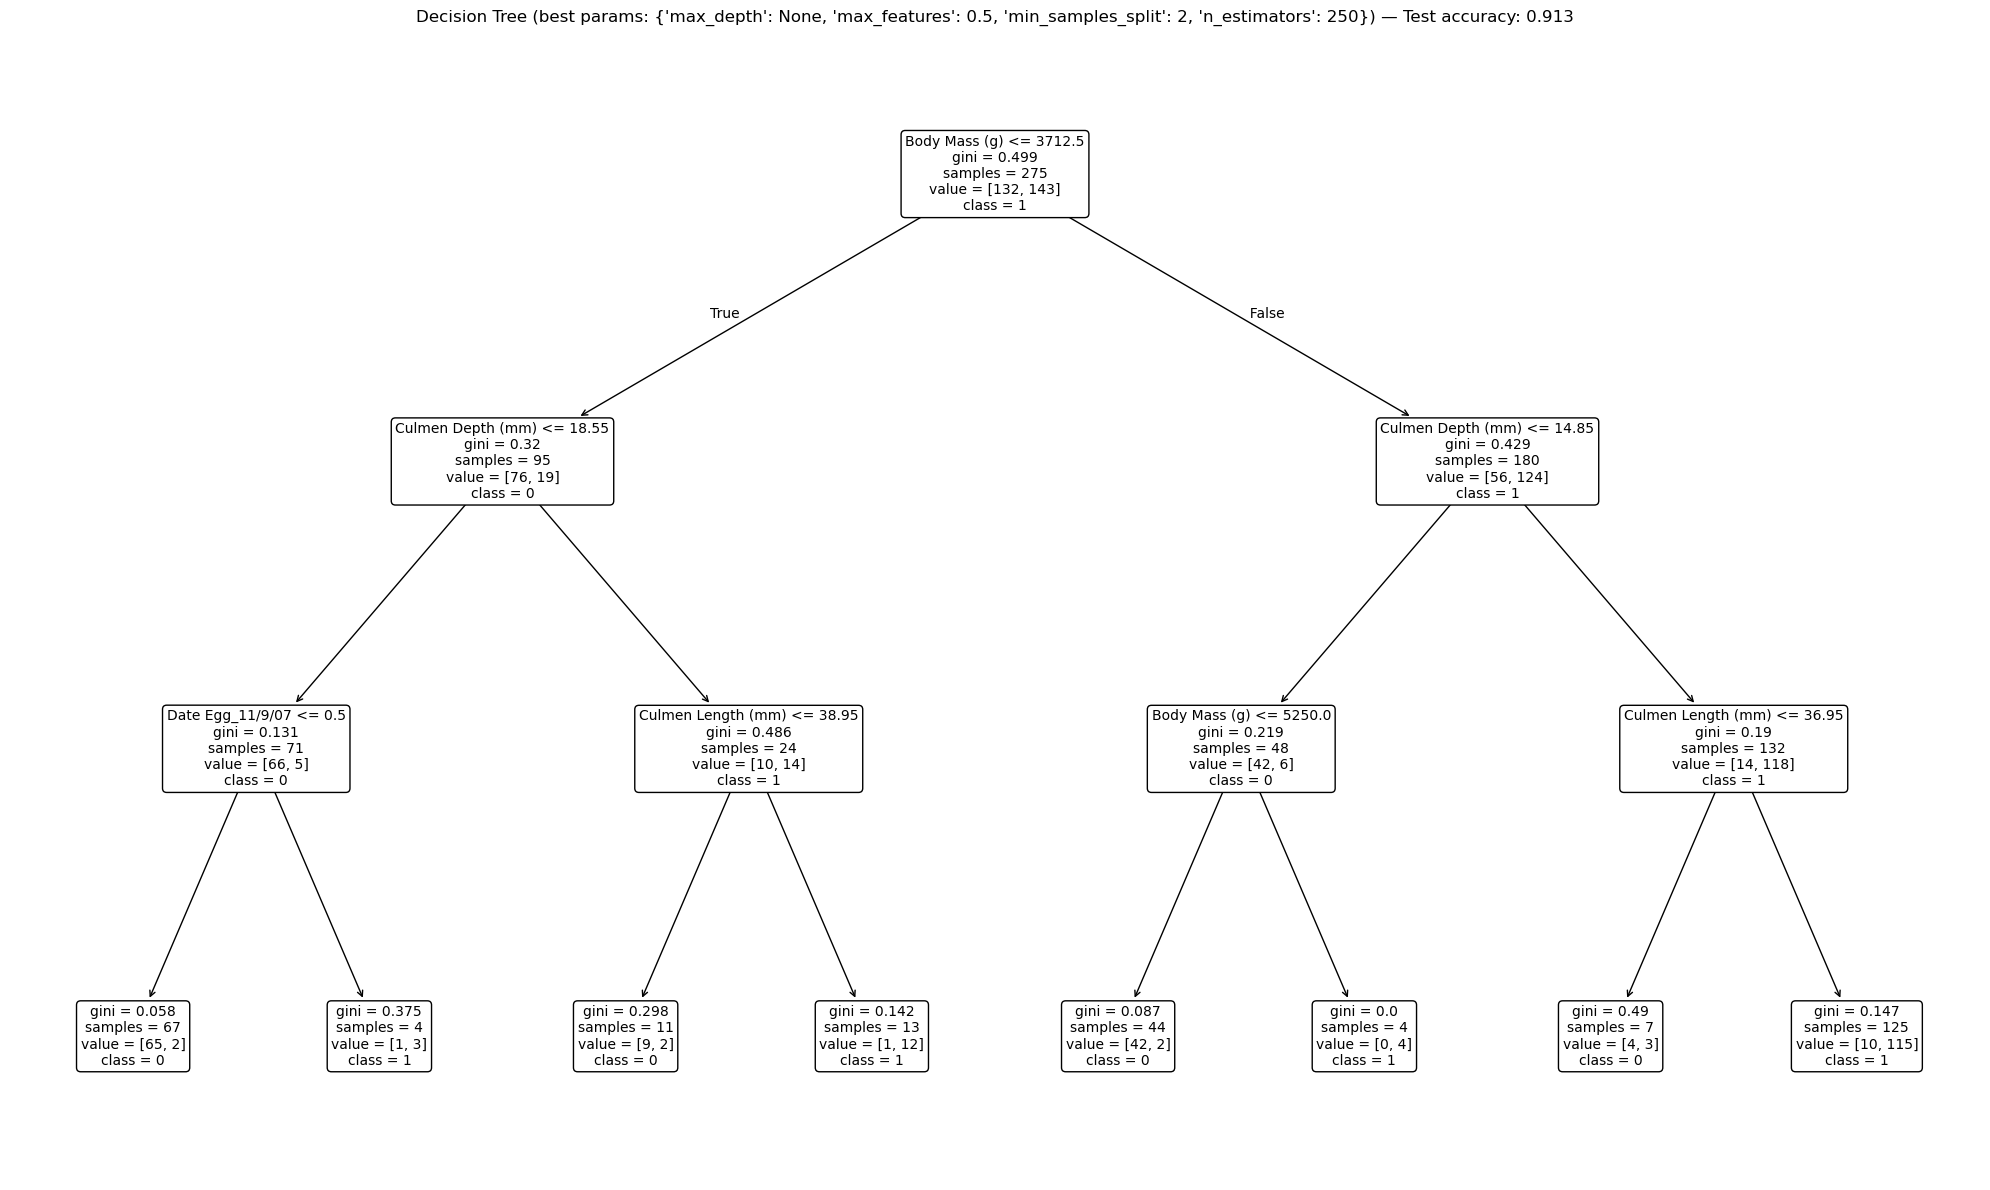

In [81]:
plt.figure(figsize=(20,12))
plot_tree(best_dt, feature_names=X.columns, class_names=np.unique(y).astype(str),
          filled=False, rounded=True, fontsize=10)
plt.title(f"Decision Tree (best params: {grid.best_params_}) — Test accuracy: {acc:.3f}")
plt.tight_layout()
plt.savefig('decision_tree_plot.png', dpi=150)
plt.show()

# BOOSTING MODELS

## AdaBoost

In [56]:
ada = AdaBoostClassifier(n_estimators=200, learning_rate=0.8, random_state=42)
ada.fit(X_train, y_train)

AdaBoostClassifier(learning_rate=0.8, n_estimators=200, random_state=42)

In [57]:
y_pred_ada = ada.predict(X_test)

In [58]:
acc = accuracy_score(y_test, y_pred)
acc

0.855072463768116

In [59]:
param_grid = { "n_estimators": [50, 100, 200, 300], "learning_rate": [0.01, 0.1, 0.5, 1.0]}

In [60]:
gs = GridSearchCV(AdaBoostClassifier(random_state=42), param_grid, cv=4, scoring='accuracy', n_jobs=-1, verbose=0)
gs.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=AdaBoostClassifier(random_state=42), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.1, 0.5, 1.0],
                         'n_estimators': [50, 100, 200, 300]},
             scoring='accuracy')

In [61]:
best_ada = gs.best_estimator_
best_ada

AdaBoostClassifier(n_estimators=300, random_state=42)

In [62]:
y_pred = best_ada.predict(X_test)
acc = accuracy_score(y_test, y_pred)
acc

0.9130434782608695

In [63]:
print("AdaBoost - Best params:", gs.best_params_)

AdaBoost - Best params: {'learning_rate': 1.0, 'n_estimators': 300}


In [64]:
print("AdaBoost - Test accuracy:", acc)
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))

AdaBoost - Test accuracy: 0.9130434782608695

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.88      0.91        33
           1       0.89      0.94      0.92        36

    accuracy                           0.91        69
   macro avg       0.92      0.91      0.91        69
weighted avg       0.91      0.91      0.91        69


Confusion Matrix:
 [[29  4]
 [ 2 34]]


## Gradient Boosting

In [65]:
param_grid_gb = { "n_estimators": [100, 200, 300], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 4, 6], "min_samples_leaf": [1, 2, 4]}

In [66]:
gs_gb = GridSearchCV(GradientBoostingClassifier(random_state=42), param_grid_gb, cv=4, scoring='accuracy', n_jobs=-1, verbose=0)
gs_gb.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=GradientBoostingClassifier(random_state=42),
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 6], 'min_samples_leaf': [1, 2, 4],
                         'n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [67]:
best_gb = gs_gb.best_estimator_
y_pred_gb = best_gb.predict(X_test)
acc_gb = accuracy_score(y_test, y_pred_gb)
acc_gb

0.855072463768116

In [68]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_gb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_gb))


Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.79      0.84        33
           1       0.82      0.92      0.87        36

    accuracy                           0.86        69
   macro avg       0.86      0.85      0.85        69
weighted avg       0.86      0.86      0.85        69


Confusion Matrix:
 [[26  7]
 [ 3 33]]


## XGBoost

In [69]:
 param_grid_xgb = {"n_estimators": [100, 200, 400], "learning_rate": [0.01, 0.05, 0.1], "max_depth": [3, 4, 6], "subsample": [0.6, 0.8, 1.0],
                   "colsample_bytree": [0.6, 0.8, 1.0]}

In [70]:
gs_xgb = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),
                      param_grid_xgb, cv=4, scoring='accuracy', n_jobs=-1, verbose=0)
gs_xgb.fit(X_train, y_train)

GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constrain...
                                     max_delta_step=None, max_depth=None,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [3, 4, 6],
                         'n_estimators': [100, 200, 400],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='accuracy')

In [71]:
best_xgb = gs_xgb.best_estimator_
best_xgb

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, ...)

In [72]:
y_pred_xgb = best_xgb.predict(X_test)
acc_xgb = accuracy_score(y_test, y_pred_xgb)
acc_xgb

0.8840579710144928

In [73]:
print("\nClassification Report:\n", classification_report(y_test, y_pred_xgb))
print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred_xgb))


Classification Report:
               precision    recall  f1-score   support

           0       0.93      0.82      0.87        33
           1       0.85      0.94      0.89        36

    accuracy                           0.88        69
   macro avg       0.89      0.88      0.88        69
weighted avg       0.89      0.88      0.88        69


Confusion Matrix:
 [[27  6]
 [ 2 34]]


| S.No. | Rank  | Model              | Defult Acuuracy| Tuning Acuuracy|
| ----- |------ | ------------------ | -------------- | ---------------|
|  1    |   2   | **Ada Boost**      | -              | 0.91           |
|  2    |   3   | **XG Boost**       | -              | 0.88           |
|  3    |   3   | **SVM**            | -              | 0.88           |
|  4    |   4   | **RF**             | 0.86           | 0.87           |
|  5    |   5   | **GradientBoost**  | -              | 0.86           |
|  6    |   6   | **Logistic**       | 0.84           | -              |
|  7    |   7   | **DT**             | 0.83           | 0.83           |
|  8    |   1   | **Naive Bayes**    | 0.62           | 0.96           |
|  9    |   8   | **KNN**            | 0.45           | 0.51           |
| ----- | ----- | ------------------ | -------------- | -------------- |